In [21]:
# NOMENCLATURA DE RED

netn         = [7, 128, 64, 2]
lrate        = 0.001
epoch        = 15000
batch        = 50

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import layers
from keras.utils import np_utils
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from datetime import datetime

In [4]:
DS = pd.read_csv('dataset_SCL.csv')
DS2 = pd.read_csv('synthetic_features.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
def dif_min(data):
    fecha_o = datetime.strptime(data['Fecha-O'], '%Y-%m-%d %H:%M:%S')
    fecha_i = datetime.strptime(data['Fecha-I'], '%Y-%m-%d %H:%M:%S')
    dif_min = ((fecha_o - fecha_i).total_seconds())/60
    return dif_min

DS['dif_min'] = DS.apply(dif_min, axis = 1)

DS['atraso_15'] = np.where(DS['dif_min'] > 15, 1, 0)

In [6]:
# este código es para generar un array con los atrasos / tasas de atraso
def calcular_tasa(df, columna):
    
    dic_atrasos = {}
    for _, row in df.iterrows():
        if row['atraso_15'] == 1:
            if row[columna] not in dic_atrasos:
                dic_atrasos[row[columna]] = 1
            else:
                dic_atrasos[row[columna]] += 1
    
    total_values = df[columna].value_counts()
    
    dic_tasas = {}
    for name, total in total_values.iteritems():
        if name in dic_atrasos:
            dic_tasas[name] = round(total / dic_atrasos[name], 2)
        else:
            dic_tasas[name] = 0
            
    return pd.DataFrame.from_dict(data = dic_tasas, orient = 'index', columns = ['Tasa (%)'])


# calculo de tasas por cada columna
tasas_destinos   = calcular_tasa(DS, 'SIGLADES')
tasas_aerolineas = calcular_tasa(DS, 'OPERA')
tasas_meses      = calcular_tasa(DS, 'MES')
tasas_dias       = calcular_tasa(DS, 'DIANOM')
tasas_temporada  = calcular_tasa(DS2, 'temporada_alta')
tasas_tipovuelo  = calcular_tasa(DS, 'TIPOVUELO')
tasa_periododia  = calcular_tasa(DS2, 'periodo_dia')

In [7]:
def tasa(palabra, lista):
    if (palabra in lista.index):
      return (lista.to_numpy()[lista.index.tolist().index(palabra), 0])/100 #convierte lista a np y retorna el elemento en la posición de index (la posición de la palabra en la otra lista)
    else:
      return 0


In [8]:
# DATASET ENTRADAS (lee el csv y luego pasa las variables a un array para entrenar la red)
# La idea es que las entradas de la red sea strings y el sistema lo convierta a float, para el análisis de la red

aux1 = []
cont = 0

for fila in DS.iterrows():
  aux  = []
  aux.append(tasa(fila[1][17], tasas_destinos))               # Destino (string)
  aux.append(tasa(fila[1][15], tasas_aerolineas))             # Aerolínea (string)
  aux.append(tasa(fila[1][11], tasas_meses))                  # Mes (número)
  aux.append(tasa(fila[1][13], tasas_dias))                   # día (string)
  aux.append(tasa(DS2.to_numpy()[cont][0], tasas_temporada))  # Temporada (Bool, 0 baja, 1 alta)
  aux.append(tasa(fila[1][14], tasas_tipovuelo))              # Tipo vuelo (Char, N nacional, I internacional)
  aux.append(tasa(DS2.to_numpy()[cont][3], tasa_periododia))  # periodo día (string)

  aux1.append(np.asarray(aux))
  cont += 1


In [9]:
x_train = np.array(aux1) # Array con vectores de csv
y_train = DS['atraso_15'] # Array salidas (1/0)


In [10]:
x_train = np.asarray(x_train).astype(np.float32)
y_train = np_utils.to_categorical(y_train)

In [22]:
# Construcción de red

net = Sequential()
net.add(Dense(netn[1], input_dim=netn[0], activation='sigmoid'))
for x in netn[2:-1]:
    net.add(Dense(x, activation='sigmoid'))
net.add(Dense(len(y_train[0]), activation='softmax'))

opt = Adam(lr=lrate)

In [23]:
# ENTRENAMIENTO DE RED GENERO
 # Ajustes de modelo de entrenamiento
  
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3)


net.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model = net.fit(x_train, y_train, epochs=epoch,batch_size=batch)

net.save("/content/drive/My Drive/CHALLENGE/red_aviones.h5")
print("******* RED GUARDADA *******")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
230/230 [==============================] - 1s 3ms/step - loss: 0.4390 - accuracy: 0.8161
Epoch 12502/15000
230/230 [==============================] - 1s 3ms/step - loss: 0.4364 - accuracy: 0.8231
Epoch 12503/15000
230/230 [==============================] - 1s 3ms/step - loss: 0.4333 - accuracy: 0.8216
Epoch 12504/15000
230/230 [==============================] - 1s 3ms/step - loss: 0.4414 - accuracy: 0.8156
Epoch 12505/15000
230/230 [==============================] - 1s 3ms/step - loss: 0.4393 - accuracy: 0.8219
Epoch 12506/15000
230/230 [==============================] - 1s 3ms/step - loss: 0.4334 - accuracy: 0.8259
Epoch 12507/15000
230/230 [==============================] - 1s 3ms/step - loss: 0.4332 - accuracy: 0.8247
Epoch 12508/15000
230/230 [==============================] - 1s 3ms/step - loss: 0.4338 - accuracy: 0.8235
Epoch 12509/15000
230/230 [==============================] - 1s 3ms/step - loss: 0.4367 - accur

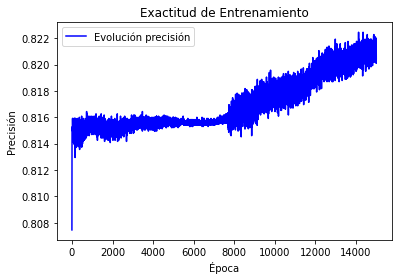

In [24]:
# VISUALIZACIÓN DE ENTRENAMIENTO

plt.figure()
epoch_values = list(range(epoch))
plt.plot(epoch_values, model.history['accuracy'], label='Evolución precisión',c='b')
 
plt.title('Exactitud de Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

In [ ]:
# Con esto se genera la matriz de confusión

y_true = []
y_pred = []
cont=0
for i in range(len(x_valid)):
  if (i % int(len(x_valid)/100) == 0):
    cont+=1
    print(cont)
  y_pred.append(np.where(net.predict(np.array([x_valid[i]])) == np.amax(net.predict(np.array([x_valid[i]]))))[1][0])
  y_true.append(np.where(y_valid[i] == np.amax(y_valid[i]))[0][0])

In [28]:
from sklearn.metrics import confusion_matrix
conf_arr = confusion_matrix(y_true, y_pred)

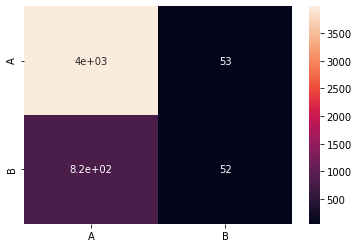

In [31]:
# Se define una lista para que la matriz ocupe como layers.
import seaborn as sn
alphabet = ['A','B']

df_cm = pd.DataFrame(conf_arr, index = [i for i in alphabet],
                     columns = [i for i in alphabet])
plt.figure()
sn.heatmap(df_cm, annot=True)